In [6]:
## imports

import visualisation
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

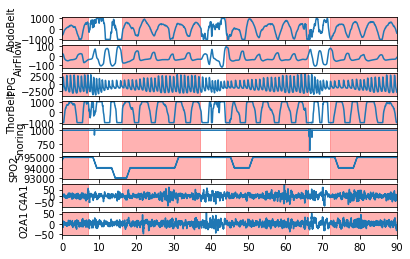

In [7]:
### Visualisation of the data

PATH_TO_TRAINING_DATA = "additional_files_dreem/X_train.h5"
PATH_TO_TRAINING_TARGET = "y_train_tX9Br0C.csv"
h5_file = h5py.File(PATH_TO_TRAINING_DATA, 'r')
mask = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))
visualisation.visualise_index(1625, h5_file, mask) # weird snoring score around 1619 -> sensor disconnected ?

In [21]:
## Exploration of the data

myFile = np.genfromtxt('y_train_tX9Br0C.csv', delimiter=',')
myFile = myFile[1:] ## removing first row y_0, y_2,..., y_89
myFile = myFile[:,1:] ## removing first columns corresponding to IDs

## number of apnea seconds

Number of seconds of apnea over number of seconds of sleep in % for each window of all patients : 
 
 [17.77777778  0.          0.         ...  0.          0.
  0.        ]


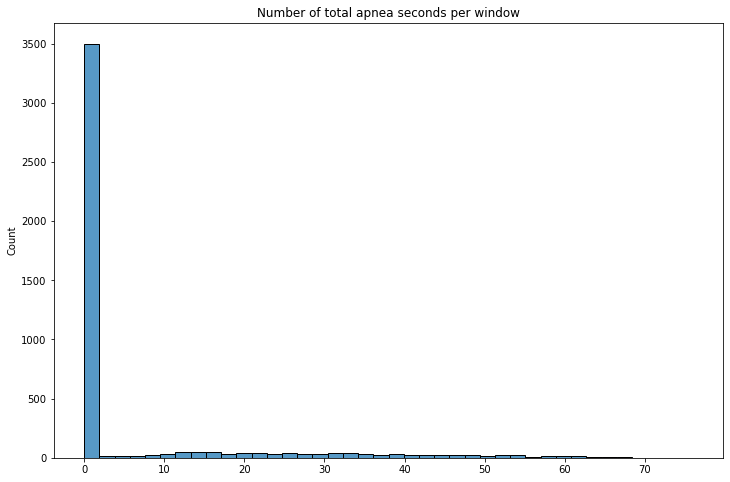

In [10]:
## nb of apnea seconds in total per window

nb_windows_per_patient = 200
nb_patients = 22
window_time = 90

sums = np.sum(myFile, axis=1)
print('Number of seconds of apnea over number of seconds of sleep in % for each window of all patients : \n \n',100 * sums/(window_time))

plt.figure(figsize =(12,8))
sns.histplot(sums, bins=40)
plt.title("Number of total apnea seconds per window")
plt.show()

Number of seconds of apnea over number of seconds of sleep in % for each patient : 
 
 [ 0.98888889  2.9         9.56111111  7.96666667 27.23888889  7.96666667
  5.75        6.95       13.77222222  1.12777778 10.30555556  2.11666667
 12.18333333  1.63333333  1.15        3.40555556  5.93333333  0.74444444
 19.21111111  1.62777778  1.38888889  7.26666667]


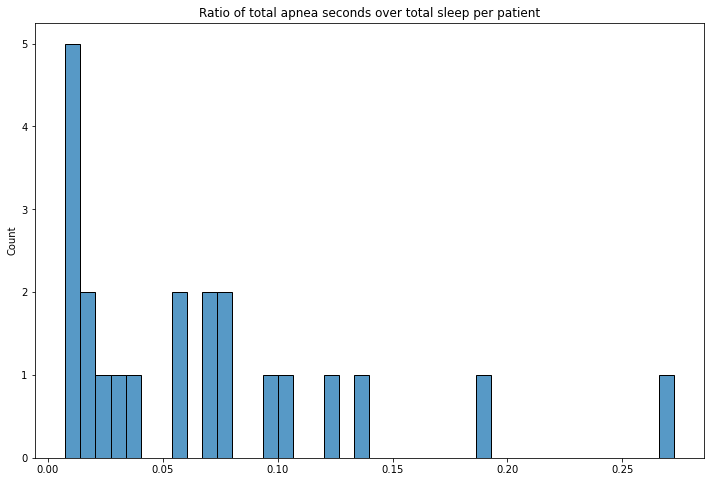

In [22]:
## Let us see how the number total of apnea seconds is correlated to the patient we consider
patients_buckets = np.zeros(nb_patients)

for i in range(nb_patients):
    patients_buckets[i] = np.sum(sums[i * nb_windows_per_patient:(i+1)*nb_windows_per_patient])
    
print('Number of seconds of apnea over number of seconds of sleep in % for each patient : \n \n',100 * patients_buckets/(window_time*nb_windows_per_patient))

plt.figure(figsize =(12,8))
sns.histplot(patients_buckets/(window_time*nb_windows_per_patient), bins=40)
plt.title("Ratio of total apnea seconds over total sleep per patient")
plt.show()

In [23]:
starts, ends = list(), list()
for i in range(np.shape(myFile)[0]):
    for j in range(np.shape(myFile)[1]):
        if  j==0 and myFile[i,j] == 1:
            starts.append([i,j])
        elif myFile[i,j] ==1 and myFile[i, j-1]==0:
            starts.append([i,j])
        if j+1 ==np.shape(myFile)[1] and myFile[i, j]==1:
            ends.append([i,j])
        else : 
            if myFile[i,j] ==1 and myFile[i, j+1]==0:
                ends.append([i,j])


In [24]:
starts, ends = np.array(starts), np.array(ends)

Number of apnea events per patient [  12.   29.  128.  208.  414.  492.  541.  609.  765.  781.  896.  914.
 1045. 1064. 1075. 1123. 1188. 1200. 1370. 1391. 1412. 1486.]


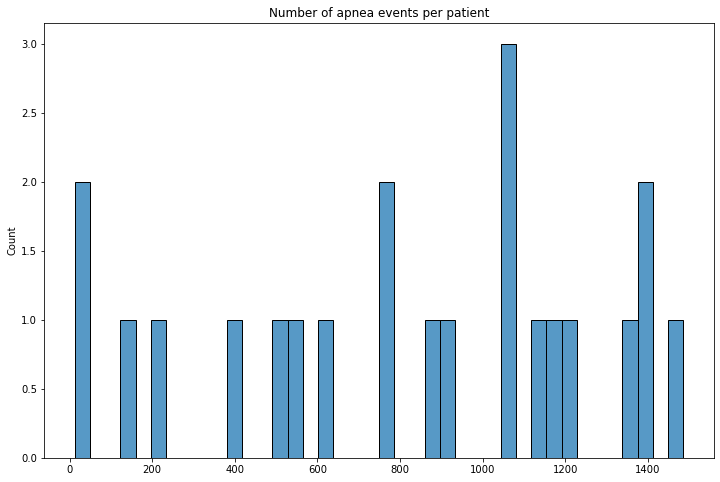

In [25]:
nb_buckets_per_patient = np.zeros(nb_patients)

for patient in range(nb_patients):
    condition = (np.where(patient* nb_windows_per_patient<=np.asarray(starts)[:,0]) and (np.asarray(starts)[:,0]<= (patient+1)*nb_windows_per_patient))
    nb_buckets_per_patient[patient] = len(np.where(condition)[0])
    
print('Number of apnea events per patient', nb_buckets_per_patient)

plt.figure(figsize =(12,8))
sns.histplot(nb_buckets_per_patient, bins=40)
plt.title("Number of apnea events per patient")
plt.show()

Location of apnea events (1st and 2nd columns) and their duration (3rd column)over all patients 
 
 [[   0.   52.   16.]
 [  18.   34.   12.]
 [  18.   72.   18.]
 ...
 [4396.    0.   12.]
 [4396.   28.   32.]
 [4396.   75.   15.]]


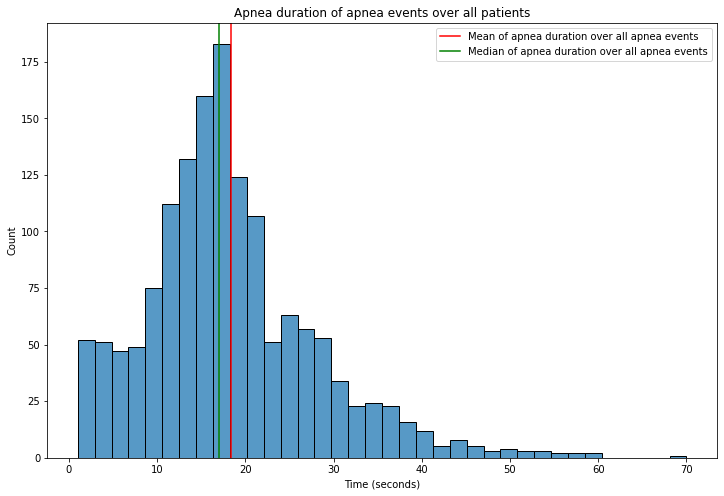

In [26]:
apnea_events = np.zeros((np.shape(starts)[0], 3)) ## each column corresponds to row, column, duration of apnea event
for k in range(np.shape(starts)[0]): 
    apnea_events[k] = [starts[k,0], starts[k,1], (ends-starts)[k,1] + 1]

print("Location of apnea events (1st and 2nd columns) and their duration (3rd column)over all patients \n \n", apnea_events)

## average of apnea duration over all patients 

plt.figure(figsize=(12,8))
sns.histplot(apnea_events[:,2])
plt.axvline(x=apnea_events[:,2].mean(), color="red",label='Mean of apnea duration over all apnea events')
plt.axvline(x=np.median(apnea_events[:,2]), color="g",label='Median of apnea duration over all apnea events')
plt.title('Apnea duration of apnea events over all patients')
plt.xlabel("Time (seconds)")
plt.legend()
plt.show()

In [27]:
## let's see how this duration is correlated to the patient we consider

duration_per_patient = list()
k=0
for i in range(nb_patients):
    list_duration_patient_i=[]
    while apnea_events[k,0]<= (i+1) * nb_windows_per_patient:
        list_duration_patient_i.append(apnea_events[k,2])
        k+=1
        if (k == np.shape(apnea_events)[0]): break
    duration_per_patient.append(list_duration_patient_i)

In [28]:
df_per_patient = pd.DataFrame(duration_per_patient).transpose() ## each column is a patient, all rows are his 
                                                                ## apnea events duration
df_per_patient

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,16.0,44.0,20.0,18.0,27.0,15.0,6.0,15.0,14.0,7.0,...,19.0,12.0,21.0,3.0,24.0,13.0,3.0,3.0,2.0,16.0
1,12.0,12.0,18.0,12.0,20.0,17.0,9.0,16.0,13.0,13.0,...,6.0,18.0,8.0,12.0,8.0,12.0,28.0,18.0,15.0,18.0
2,18.0,51.0,2.0,13.0,46.0,22.0,28.0,23.0,18.0,13.0,...,29.0,24.0,7.0,14.0,7.0,15.0,29.0,22.0,12.0,17.0
3,16.0,26.0,13.0,8.0,4.0,23.0,26.0,19.0,3.0,3.0,...,15.0,11.0,40.0,20.0,18.0,12.0,14.0,14.0,13.0,14.0
4,26.0,15.0,20.0,20.0,16.0,23.0,26.0,1.0,9.0,7.0,...,9.0,14.0,25.0,16.0,7.0,2.0,13.0,12.0,13.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


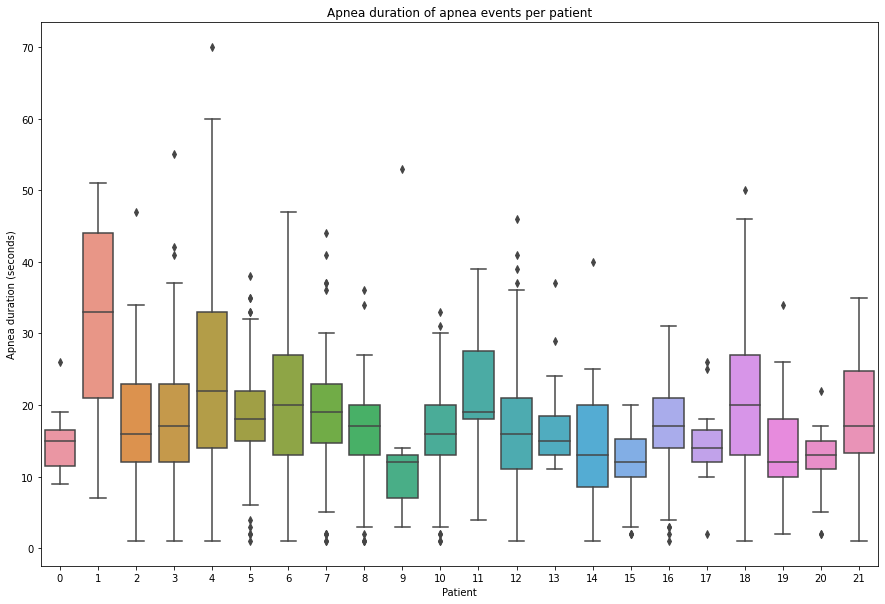

In [29]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df_per_patient)
plt.title('Apnea duration of apnea events per patient')
plt.xlabel("Patient")
plt.ylabel("Apnea duration (seconds)")
plt.show()